# Development Notebook for extracting icebergs from DEMs

by Jessica Scheick

Workflow based on previous methods and code developed by JScheick for Scheick et al 2019 *Remote Sensing*.

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import hvplot.xarray
import holoviews as hv
hv.extension('bokeh','matplotlib')
from holoviews import dim, opts
import datetime as dt
import panel as pn
pn.extension()

In [ ]:
%load_ext autoreload
# from icebath.core import berggdf as bdf
import icebath as icebath
from icebath.core import build_xrds
from icebath.utils import raster_ops as raster_ops
from icebath.utils import vector_ops as vector_ops
from icebath.core import fl_ice_calcs as icalcs
from icebath.core import build_gdf
%autoreload 2

## Read in DEMs and plot

In [35]:
#auto-fill dates and times still needed!!
ds = build_xrds.xrds_from_dir('/home/jovyan/icebath/notebooks/supporting_docs/Elevation/ArcticDEM/Regridded_50m_tiles/n69w052/')

NOTE: currently dates and times are hard-coded in. Need to automate this in read_DEM still
Please note the transform is computed assuming a coordinate reference system where x(min) is west and y(min) is south


/home/jovyan/icebath/icebath/core/build_xrds.py:15: UserWarning: This function currently assumes a constant grid and EPSG for all input files
  warnings.warn("This function currently assumes a constant grid and EPSG for all input files")


In [38]:
scrolldem = ds['elevation'].hvplot.image(x='x', y='y',rasterize=True, aspect='equal', cmap='magma', #dynamic=False
                       xlabel="x (km)", ylabel="y (km)")
scrolldem

/srv/conda/envs/notebook/lib/python3.7/site-packages/holoviews/operation/datashader.py:825: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  xarr = xarr.transpose(*dims)


:DynamicMap   [dtime]
   :Image   [x,y]   (elevation)

In [6]:
ds

<xarray.Dataset>
Dimensions:    (dtime: 2, x: 459, y: 363)
Coordinates:
  * y          (y) float64 -2.269e+06 -2.269e+06 ... -2.251e+06 -2.251e+06
  * x          (x) float64 -2.495e+05 -2.494e+05 ... -2.266e+05 -2.266e+05
  * dtime      (dtime) datetime64[ns] 2012-06-29T15:26:30 2010-08-14T15:34:00
Data variables:
    elevation  (dtime, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    transform:      | 50.00, 0.00,-249500.00|\n| 0.00,-50.00,-2251200.00|\n| ...
    crs:            +init=epsg:3413
    res:            (50.0, 50.0)
    is_tiled:       0
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

### Get and Apply Land Mask
**Note: requires a shapefile of the land areas in the ROI**

The default is to use a shapefile of Greenland: `shpfile='/home/jovyan/icebath/notebooks/supporting_docs/Land_region.shp'`, but an alternative file can be specified.

Underlying code is based on: https://gis.stackexchange.com/questions/357490/mask-xarray-dataset-using-a-shapefile
Other results used rioxarray (which isn't on my current working environment), and my previous work did it all manually with gdal.

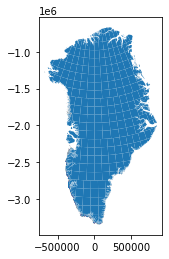

In [104]:
shpfl.geometry.plot()

/srv/conda/envs/notebook/lib/python3.7/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


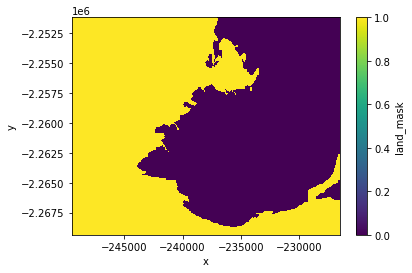

In [37]:
ds=ds.bergxr.get_mask(req_dim=['x','y'], req_vars=None, name='land_mask')
ds.land_mask.plot()

In [5]:
#land = ds.where(ds.land_mask==True).hvplot(x='x', y='y', rasterize=True, aspect='equal')
# land_col = {1:'brown', 0:'purple'} #hv.Cycle(['purple','brown'])
# land = ds.hvplot(x='x', y='y', z='land_mask', rasterize=True, aspect='equal', cmap='binary')
#  cmap='magma', #dynamic=False
#                        xlabel="x (km)", ylabel="y (km)")
land = ds.hvplot(x='x', y='y', z='land_mask', aspect='equal')
land.options(color=hv.Cycle(['purple','brown']), alpha=[0,1])
# land.options(color='Category', cmap=land_col)
print(land)
land

:DynamicMap   [dtime]


:DynamicMap   [dtime]
   :Image   [x,y]   (land_mask)

In [ ]:
land_plot_data = {'x':ds.x, 'y':ds.y,
                 'color':[]}

In [36]:
scrolldem + land + scrolldem*land

:Layout
   .DynamicMap.I   :DynamicMap   [dtime]
      :Image   [x,y]   (elevation)
   .DynamicMap.II  :DynamicMap   [dtime]
      :Image   [x,y]   (land_mask)
   .DynamicMap.III :DynamicMap   [dtime]
      :Overlay
         .Image.I  :Image   [x,y]   (elevation)
         .Image.II :Image   [x,y]   (land_mask)

In [39]:
ds['elevation'] = ds['elevation'].where(ds.land_mask == True)

In [42]:
#TO DO: add land areas to visualization
scrolldem = ds['elevation'].hvplot.image(x='x', y='y',rasterize=True, aspect='equal', cmap='magma', #dynamic=False
                       xlabel="x (km)", ylabel="y (km)")
scrolldem

/srv/conda/envs/notebook/lib/python3.7/site-packages/holoviews/operation/datashader.py:825: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  xarr = xarr.transpose(*dims)


:DynamicMap   [dtime]
   :Image   [x,y]   (elevation)

In [22]:
ds

<xarray.Dataset>
Dimensions:       (dtime: 2, x: 459, y: 363)
Coordinates:
    land_mask     (y, x) bool True True True True ... False False False False
  * x             (x) float64 -2.495e+05 -2.494e+05 ... -2.266e+05 -2.266e+05
  * y             (y) float64 -2.269e+06 -2.269e+06 ... -2.251e+06 -2.251e+06
  * dtime         (dtime) datetime64[ns] 2012-06-29T15:26:30 2010-08-14T15:34:00
Data variables:
    elevation     (dtime, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    tidal_corr    (dtime) float64 -0.9888 0.7373
    min_tidal_ht  (dtime) float64 -1.036 -1.039
    max_tidal_ht  (dtime) float64 1.064 0.8908
Attributes:
    transform:      | 50.00, 0.00,-249500.00|\n| 0.00,-50.00,-2251200.00|\n| ...
    crs:            +init=epsg:3413
    res:            (50.0, 50.0)
    is_tiled:       0
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    offset_names:   tidal_corr

### Apply Tidal Correction
**Note: I need to check and make sure that the tidal correction should be subtracted and not added!**

Uses Tyler Sutterly's pyTMD library

In [41]:
#TO DO: get actual dates and times for this correction!
ds=ds.bergxr.tidal_corr(loc=["JI"])

Note that tide model, model location, and epsg are hard coded in!


In [32]:
ds

<xarray.Dataset>
Dimensions:       (dtime: 2, x: 459, y: 363)
Coordinates:
    land_mask     (y, x) bool True True True True ... False False False False
  * x             (x) float64 -2.495e+05 -2.494e+05 ... -2.266e+05 -2.266e+05
  * y             (y) float64 -2.269e+06 -2.269e+06 ... -2.251e+06 -2.251e+06
  * dtime         (dtime) datetime64[ns] 2012-06-29T15:26:30 2010-08-14T15:34:00
Data variables:
    elevation     (dtime, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    tidal_corr    (dtime) float64 -0.9888 0.7373
    min_tidal_ht  (dtime) float64 -1.036 -1.039
    max_tidal_ht  (dtime) float64 1.064 0.8908
Attributes:
    transform:      | 50.00, 0.00,-249500.00|\n| 0.00,-50.00,-2251200.00|\n| ...
    crs:            +init=epsg:3413
    res:            (50.0, 50.0)
    is_tiled:       0
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    offset_names:   tidal_corr

## Iceberg Delineation

In [52]:
#why does the first one have a different format than the rest?
# what is matplotlib outputting, and are there even any holes I need to remove? Is there another way to approach this?
# is this even the problem?
ds=ds.bergxr.get_icebergs(threshold=650)
ds

4
[[array([ -249475.        , -2262285.55328522]), array([ -249425.        , -2262285.39360933]), array([ -249414.60639067, -2262275.        ]), array([ -249415.18154743, -2262225.        ]), array([ -249415.51609322, -2262175.        ]), array([ -249415.21142413, -2262125.        ]), array([ -249415.60494412, -2262075.        ]), array([ -249415.60384184, -2262025.        ]), array([ -249425.        , -2262015.60384184]), array([ -249475.        , -2262015.39266942]), array([ -249475.        , -2262285.55328522])]]
[array([ -249475.        , -2262285.55328522]), array([ -249425.        , -2262285.39360933]), array([ -249414.60639067, -2262275.        ]), array([ -249415.18154743, -2262225.        ]), array([ -249415.51609322, -2262175.        ]), array([ -249415.21142413, -2262125.        ]), array([ -249415.60494412, -2262075.        ]), array([ -249415.60384184, -2262025.        ]), array([ -249425.        , -2262015.60384184]), array([ -249475.        , -2262015.39266942]), array([

<xarray.Dataset>
Dimensions:        (dtime: 2, x: 459, y: 363)
Coordinates:
    land_mask      (y, x) bool True True True True ... False False False False
  * x              (x) float64 -2.495e+05 -2.494e+05 ... -2.266e+05 -2.266e+05
  * y              (y) float64 -2.269e+06 -2.269e+06 ... -2.251e+06 -2.251e+06
  * dtime          (dtime) datetime64[ns] 2012-06-29T15:26:30 2010-08-14T15:34:00
Data variables:
    elevation      (dtime, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    tidal_corr     (dtime) float64 -0.9888 0.7373
    min_tidal_ht   (dtime) float64 -1.036 -1.039
    max_tidal_ht   (dtime) float64 1.064 0.8908
    berg_outlines  (dtime) object [] [[(-249475.0, -2262285.5532852164), (-249425.0, -2262285.393609334), (-249414.60639066607, -2262275.0), (-249415.18154742726, -2262225.0), (-249415.51609321625, -2262175.0), (-249415.21142412839, -2262125.0), (-249415.6049441217, -2262075.0), (-249415.60384183962, -2262025.0), (-249425.0, -2262015.60384184), (-249475.0, -2262015.3926694226), (-249475.0, -2262285.5532852164)], [(-230325.0, -2269179.433640652), (-230275.0, -2269179.401038788), (-230225.00000000003, -2269179.5371610983), (-230175.0, -2269180.0800053044), (-230125.0, -2269180.2323532337), (-230075.00000000003, -2269180.41221428), (-230025.0, -2269180.5322727985), (-229975.0, -2269180.784178163), (-229925.0, -2269181.881155547), (-229875.0, -2269181.595378249), (-229868.404621751, -2269175.0), (-229825.0, -2269129.754595428), (-229775.0, -2269129.9095863025), (-229725.0, -2269129.937381341), (-229720.0626186588, -2269125.0), (-229725.0, -2269120.062618659), (-229775.0, -2269120.0904136975), (-229825.0, -2269120.245404572), (-229871.63403475308, -2269075.0), (-229875.0, -2269071.634034753), (-229925.0, -2269070.750090816), (-229975.0, -2269071.0011173724), (-230025.0, -2269071.360030633), (-230075.0, -2269071.0004974287), (-230125.0, -2269070.83357578), (-230175.0, -2269071.0629611337), (-230225.0, -2269071.524091691), (-230275.0, -2269072.3184998557), (-230325.0, -2269072.8809694634), (-230327.11903053627, -2269075.0), (-230327.80812819017, -2269125.0), (-230329.4336406518, -2269175.0), (-230325.0, -2269179.433640652)], [(-237975.0, -2253975.578714822), (-237966.4630523122, -2253975.0), (-237975.0, -2253974.421285178), (-237975.57871482198, -2253975.0), (-237975.0, -2253975.578714822)], [(-237575.0, -2252182.9637457835), (-237567.0362542167, -2252175.0), (-237524.99999999997, -2252126.8718878245), (-237512.0616238099, -2252125.0), (-237525.0, -2252076.736738218), (-237525.43114869235, -2252075.0), (-237525.66709572813, -2252025.0), (-237535.80063528684, -2251975.0), (-237572.83127005963, -2251925.0), (-237575.0, -2251924.9778024517), (-237625.0, -2251919.7117228294), (-237665.4264823828, -2251875.0), (-237675.0, -2251865.4264823827), (-237725.0, -2251862.6127249794), (-237737.38727502065, -2251875.0), (-237738.231501367, -2251925.0), (-237738.75127717727, -2251975.0), (-237725.0, -2251988.751277177), (-237685.77700540156, -2252025.0), (-237725.0, -2252058.224394822), (-237741.77560517777, -2252075.0), (-237725.0, -2252091.7756051775), (-237675.0, -2252089.354323434), (-237637.19587390625, -2252125.0), (-237625.0, -2252137.1958739064), (-237582.96374578332, -2252175.0), (-237575.0, -2252182.9637457835)]]
Attributes:
    transform:       | 50.00, 0.00,-249500.00|\n| 0.00,-50.00,-2251200.00|\n|...
    crs:             +init=epsg:3413
    res:             (50.0, 50.0)
    is_tiled:        0
    nodatavals:      (nan,)
    scales:          (1.0,)
    offsets:         (0.0,)
    AREA_OR_POINT:   Area
    offset_names:    tidal_corr
    berg_threshold:  650

In [18]:
ds=ds.bergxr.get_icebergs(threshold=10)
ds

263
211
<class 'list'>
199
163
<class 'list'>


<xarray.Dataset>
Dimensions:        (dtime: 2, x: 459, y: 363)
Coordinates:
    land_mask      (y, x) bool True True True True ... False False False False
  * x              (x) float64 -2.495e+05 -2.494e+05 ... -2.266e+05 -2.266e+05
  * y              (y) float64 -2.269e+06 -2.269e+06 ... -2.251e+06 -2.251e+06
  * dtime          (dtime) datetime64[ns] 2012-06-29T15:26:30 2010-08-14T15:34:00
Data variables:
    elevation      (dtime, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    tidal_corr     (dtime) float64 -0.9888 0.7373
    min_tidal_ht   (dtime) float64 -1.036 -1.039
    max_tidal_ht   (dtime) float64 1.064 0.8908
    berg_outlines  (dtime) object [array([[ -232725.        , -2267020.77742515],
       [ -232679.22257485, -2266975.        ],
       [ -232675.        , -2266970.80668146],
       ...,
       [ -232775.        , -2266970.80961096],
       [ -232770.77742515, -2266975.        ],
       [ -232725.        , -2267020.77742515]]), array([[ -236375.        , -2266628.74697919],
       [ -236378.96310471, -2266625.        ],
       [ -236425.        , -2266578.96310471],
       [ -236428.83433492, -2266575.        ],
       [ -236428.62441111, -2266525.        ],
       [ -236425.        , -2266521.11960769],
       [ -236375.        , -2266521.18248976],
       [ -236371.2860907 , -2266525.        ],
       [ -236325.        , -2266571.2860907 ],
       [ -236278.7139093 , -2266525.        ],
       [ -236278.86155987, -2266475.        ],
       [ -236275.        , -2266471.22251473],
       [ -236228.77748527, -2266425.        ],
       [ -236225.        , -2266421.15629773],
       [ -236220.98904159, -2266425.        ],
       [ -236221.25439824, -2266475.        ],
       [ -236221.36267286, -2266525.        ],
       [ -236221.33165764, -2266575.        ],
       [ -236221.17260245, -2266625.        ],
       [ -236225.        , -2266628.97384717],
       [ -236275.        , -2266628.89249593],
       [ -236325.        , -2266628.82398557],
       [ -236375.        , -2266628.74697919]]), array([[ -239525.        , -2266333.63941417],
       [ -239533.46696252, -2266325.        ],
       [ -239525.        , -2266313.02793902],
       [ -239509.86456786, -2266325.        ],
       [ -239525.        , -2266333.63941417]]), array([[ -233475.        , -2266227.67855296],
       [ -233477.5573256 , -2266225.        ],
       [ -233525.        , -2266177.5573256 ],
       [ -233527.60150188, -2266175.        ],
       [ -233527.80297118, -2266125.        ],
       [ -233527.79811404, -2266075.        ],
       [ -233525.        , -2266072.13127599],
       [ -233477.86872401, -2266025.        ],
       [ -233477.84117709, -2265975.        ],
       [ -233475.        , -2265972.1118935 ],
       [ -233427.8881065 , -2265925.        ],
       [ -233425.        , -2265922.13294389],
       [ -233375.        , -2265922.04146179],
       [ -233372.03591484, -2265925.        ],
       [ -233372.01713943, -2265975.        ],
       [ -233372.06183313, -2266025.        ],
       [ -233372.04728471, -2266075.        ],
       [ -233372.10483564, -2266125.        ],
       [ -233372.07064128, -2266175.        ],
       [ -233372.05097685, -2266225.        ],
       [ -233375.        , -2266227.94690225],
       [ -233425.        , -2266227.86860974],
       [ -233475.        , -2266227.67855296]]), array([[ -246175.        , -2266178.00914608],
       [ -246160.35536428, -2266175.        ],
       [ -246175.        , -2266169.61729507],
       [ -246179.80245975, -2266175.        ],
       [ -246175.        , -2266178.00914608]]), array([[ -247025.        , -2266025.58190381],
       [ -247027.15567774, -2266025.        ],
       [ -247025.        , -2266024.63826056],
       [ -247024.24225237, -2266025.        ],
       [ -247025.        , -2266025.58190381]]), array([[ -235175.        , -2266027.48093268],
       [ -235177.7644354 , -2266025.        ],
       [ -235225.        , -2265977.7644354 ],
       [ -23

## Visualizing Iceberg Outlines and Histogram for a Single DEM

Consider having this in another notebook/place focused just on iceberg delineation and visualization?

In [59]:
timei=1
print(ds['dtime'].isel({'dtime':timei}))

<xarray.DataArray 'dtime' ()>
array('2010-08-14T15:34:00.000000000', dtype='datetime64[ns]')
Coordinates:
    dtime    datetime64[ns] 2010-08-14T15:34:00


In [60]:
dsdem = ds['elevation'].isel({'dtime':timei}).hvplot.image(x='x', y='y',rasterize=True, aspect='equal', cmap='magma', #dynamic=False
                       xlabel="x (km)", ylabel="y (km)")
dsdem

/srv/conda/envs/notebook/lib/python3.7/site-packages/holoviews/operation/datashader.py:825: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  xarr = xarr.transpose(*dims)


:DynamicMap   []
   :Image   [x,y]   (elevation)

In [61]:
berglines = hv.Contours(ds['berg_outlines'].values[timei])
berglines.opts(aspect="equal", color='k')
print(berglines)
berglines

:Contours   [x,y]


:Contours   [x,y]

In [63]:
bergsr = (dsdem+berglines)
# bergsr.opts(width=1000)
bergsr

:Layout
   .DynamicMap.I :DynamicMap   []
      :Image   [x,y]   (elevation)
   .Contours.I   :Contours   [x,y]

In [38]:
dsdem*berglines
# (-239533.4669625196, -2266333.639414171, -239509.86456785948, -2266313.02793902)

/srv/conda/envs/notebook/lib/python3.7/site-packages/holoviews/operation/datashader.py:825: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  xarr = xarr.transpose(*dims)


:DynamicMap   []
   :Overlay
      .Image.I    :Image   [x,y]   (elevation)
      .Contours.I :Contours   [x,y]

In [16]:
# get the surface areas of the polygons
areas = vector_ops.get_poly_area(ds['berg_outlines'].values[timei])

/home/jovyan/icebath/icebath/utils/vector_ops.py:14: UserWarning: You MUST supply the polygon vertices in a true scale coordinate system!
  warnings.warn("You MUST supply the polygon vertices in a true scale coordinate system!")


In [18]:
# NOTE: Bokah does not support math text (e.g. subscript) rendering. Will have to switch to the matplotlib backend for that...
freq, bins = np.histogram(np.log10(areas), np.arange(-2,7,0.1))
bergszdist = hv.Histogram((freq,bins))
bergszdist.opts(xlabel='$log_{10}$(Surface Area) [$log_{10}$(m$^2$)]', ylabel='Count',
                title='Iceberg Size Distribution from Contours',
               fill_color='silver', line_width=0) #, width=1000)
# bergszdist

:Histogram   [x]   (Frequency)

In [32]:
bergsr.opts.clear()
# NOTE: clearing bergsr under the hood clears dem.opts and berglines.opts but DOES NOT clear bergsr.opts
# I've filed a bug report on this

:Layout
   .HoloMap.I  :HoloMap   [dtime]
      :Image   [x,y]   (elevation)
   .Contours.I :Contours   [x,y]

In [37]:
dem.opts.info()
berglines.opts.info()
bergsr.opts.info()
bergszdist.opts.info()

:HoloMap   [dtime]
   :Image   [x,y]   (elevation)
    | Options(aspect='equal', axiswise=False, cmap='magma', colorbar=True, framewise=True, logx=False,
    |         logy=False, responsive=False, shared_axes=True, show_grid=False, show_legend=True,
    |         symmetric=False, tools=['hover'], xlabel='x (km)', ylabel='y (km)')
:Contours   [x,y]
 | Options(aspect='equal', color='k')
:Layout
   .HoloMap.I  :HoloMap   [dtime]
      :Image   [x,y]   (elevation)
       | Options(aspect='equal', axiswise=False, cmap='magma', colorbar=True, framewise=True, logx=False,
       |         logy=False, responsive=False, shared_axes=True, show_grid=False, show_legend=True,
       |         symmetric=False, tools=['hover'], xlabel='x (km)', ylabel='y (km)')
   .Contours.I :Contours   [x,y]
    | Options(aspect='equal', color='k')
:Histogram   [x]   (Frequency)
 | Options(fill_color='silver', line_width=0, title='Iceberg Size Distribution from Contours',
 |         xlabel='$log_{10}$(Surface Area)

In [19]:
# figure = pn.Column(pn.Row(dem+berglines, width=500), pn.Row(bergszdist, width=500))
# works for lining things up if you haven't also set frame_width anywhere. If you have, you'll need to remove that opt.
# I'm not sure how to remove just one opt, so might need to do hvobj.opts.clear()
# a key lesson here is the difference between opts and options. opts sets the values FOR THE OBJECT, and they're carried through whenever that object is used
# options sets the values temporarily for the current run, so the values won't be carried through
# Thus, if we do bergszdist.opts.info() after running the below, it will not have width=1000 because it was only set as an option
# This is useful for making things like axis labels and aspect ratios "mandatory" while allowing flexibility in plotting
# The suggested way to do this in the docs is to use clone=True (by default clone=False) to .opts...

pnfig = pn.Column(
    pn.Row(
        bergsr.opts(width=1000, clone=True)), # note: need to pre-combine these two figures to have a joint width or run into width vs frame_width issues
    bergszdist.opts(width=1000, shared_axes=False, clone=True))
pnfig

Column
    [0] Row
        [0] HoloViews(Layout)
    [1] HoloViews(Histogram)

## Extract Icebergs from DEM

In [9]:
timei=0
onedem=ds.isel({'dtime':timei})
onedem

<xarray.Dataset>
Dimensions:       (x: 459, y: 363)
Coordinates:
    land_mask     (y, x) bool True True True True ... False False False False
  * x             (x) float64 -2.495e+05 -2.494e+05 ... -2.266e+05 -2.266e+05
  * y             (y) float64 -2.269e+06 -2.269e+06 ... -2.251e+06 -2.251e+06
    dtime         datetime64[ns] 2012-06-29T15:26:30
Data variables:
    elevation     (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    tidal_corr    float64 -0.9888
    min_tidal_ht  float64 -1.036
    max_tidal_ht  float64 1.064
Attributes:
    transform:      | 50.00, 0.00,-249500.00|\n| 0.00,-50.00,-2251200.00|\n| ...
    crs:            +init=epsg:3413
    res:            (50.0, 50.0)
    is_tiled:       0
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    offset_names:   tidal_corr

In [28]:
import rasterio.features
import shapely.geometry
import json

In [19]:
threshold=10
thresh_dem = onedem['elevation'].values
thresh_dem[thresh_dem>=threshold] = 1
thresh_dem[thresh_dem<threshold] = 0
# polys = list(rasterio.features.shapes(onedem['elevation'].values, mask=onedem['elevation'].where(onedem.elevation>threshold), transform=onedem.attrs['transform']))
polys = list(rasterio.features.shapes(thresh_dem, transform=onedem.attrs['transform']))

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


In [31]:
print(polys[0])
shapely.geometry.shape(json.loads(str(polys[0][0]))).buffer(0).geoms

({'type': 'Polygon', 'coordinates': [[(-239900.0, -2253850.0), (-239900.0, -2253900.0), (-239850.0, -2253900.0), (-239850.0, -2253850.0), (-239900.0, -2253850.0)]]}, 0.0)


JSONDecodeError: Expecting property name enclosed in double quotes: line 1 column 2 (char 1)

In [20]:
polys = [shapely.geometry.Polygon(poly) for poly in polys]
print(len(polys))
polys = [poly.exterior.coords for poly in polys]
print(len(polys))
polys

240


AttributeError: 'tuple' object has no attribute 'exterior'

In [32]:
print(len(onedem.berg_outlines.item()))
onedem.berg_outlines.item()

208


[array([[ -239875.        , -2266706.59258052],
        [ -239843.40741948, -2266675.        ],
        [ -239875.        , -2266643.40741948],
        ...,
        [ -239925.        , -2266650.74591687],
        [ -239906.59258052, -2266675.        ],
        [ -239875.        , -2266706.59258052]]),
 array([[ -239525.        , -2266333.63941417],
        [ -239533.46696252, -2266325.        ],
        [ -239525.        , -2266313.02793902],
        [ -239509.86456786, -2266325.        ],
        [ -239525.        , -2266333.63941417]]),
 array([[ -246175.        , -2266178.00914608],
        [ -246160.35536428, -2266175.        ],
        [ -246175.        , -2266169.61729507],
        [ -246179.80245975, -2266175.        ],
        [ -246175.        , -2266178.00914608]]),
 array([[ -247025.        , -2266025.58190381],
        [ -247027.15567774, -2266025.        ],
        [ -247025.        , -2266024.63826056],
        [ -247024.24225237, -2266025.        ],
        [ -247025.   

In [32]:
gdf = build_gdf.xarray_to_gdf(ds)

(-248188.4940668482, -2267020.777425152, -230930.56579968287, -2253343.444872071)
6.314221382141113
check for a reasonable sea level adjustment
(-236228.8788071626, -2266728.568662724, -236221.1653191218, -2266721.0261528334)
nan
check for a reasonable sea level adjustment
(-236428.83433491996, -2266628.9738471666, -236220.98904159357, -2266421.156297734)
nan
check for a reasonable sea level adjustment
(-233178.2144698229, -2266578.3803321365, -232821.75894943593, -2266371.759430539)
nan
check for a reasonable sea level adjustment
(-234477.48411438114, -2266527.3865847834, -233972.43409139404, -2266172.658503011)
nan
check for a reasonable sea level adjustment
(-237528.76312696005, -2266378.6716734227, -236771.3290246126, -2265821.36362345)
nan
check for a reasonable sea level adjustment
(-239533.4669625196, -2266333.639414171, -239509.86456785948, -2266313.02793902)
8.26671028137207
check for a reasonable sea level adjustment
(-233527.8029711768, -2266227.94690225, -233372.01713943234

/home/jovyan/icebath/icebath/core/build_gdf.py:49: RuntimeWarning: invalid value encountered in greater_equal
  # values[i] = vals[vals>=onedem.attrs['berg_threshold']]
/home/jovyan/icebath/icebath/core/build_gdf.py:55: RuntimeWarning: invalid value encountered in less
  sea = bvals[bvals<onedem.attrs['berg_threshold']]
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


(-238332.81305743635, -2263332.6899166885, -237916.99099573618, -2262667.4512384627)
nan
check for a reasonable sea level adjustment
(-247289.8855351415, -2263276.343368603, -246627.68318765154, -2262403.0311492383)
6.788026332855225
check for a reasonable sea level adjustment
(-247229.16237539277, -2262729.162375393, -247194.4351907789, -2262720.837624607)
6.352631568908691
check for a reasonable sea level adjustment
(-235226.8561442862, -2262726.765627403, -234323.15088607138, -2262323.1486980547)
nan
check for a reasonable sea level adjustment
(-234826.81681303892, -2262726.7388792234, -234773.16812301482, -2262723.157817391)
nan
check for a reasonable sea level adjustment
(-247380.64953516386, -2262630.649535164, -247369.63744851344, -2262613.635389442)
0.16964936256408691
check for a reasonable sea level adjustment
(-247275.7938117197, -2262625.926792812, -247274.15910041757, -2262624.1591004175)
0.9426323771476746
check for a reasonable sea level adjustment
(-240432.9180134746, -

/srv/conda/envs/notebook/lib/python3.7/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [33]:
gdf

DEMarray  sl_adjust  \
0    [112.09694, 166.12836, 161.1461, 155.65245, 15...   6.314221   
1                                                   []        NaN   
2        [nan, nan, nan, nan, nan, nan, nan, nan, nan]        NaN   
3    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...        NaN   
4    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...        NaN   
..                                                 ...        ...   
457                                                 []        NaN   
458  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...        NaN   
459  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...        NaN   
460  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...        NaN   
461                                                 []        NaN   

                                             berg_poly fjord  \
0    POLYGON ((-232725.000 -2267020.777, -232679.22...    JI   
1    POLYGON ((-236225.000 -2266728.569, -236228.87...    JI   
2    POLYGON ((-236375.000 -2266628.747, -236378.96...    JI   
3    POLYGON ((-233075.000 -2266578.228, -233078.20...    JI   
4    POLYGON ((-234275.000 -2266527.387, -234277.54...    JI   
..                                                 ...   ...   
457  POLYGON ((-232125.000 -2255134.712, -232134.33...    JI   
458  POLYGON ((-229375.000 -2254468.265, -229331.73...    JI   
459  POLYGON ((-229175.000 -2254168.693, -229131.30...    JI   
460  POLYGON ((-239775.000 -2254124.126, -239725.87...    JI   
461  POLYGON ((-236875.000 -2253142.386, -236895.04...    JI   

                   date  tidal_ht_offset  tidal_ht_min  tidal_ht_max  
0   2012-06-29 15:26:30         -0.98881     -1.036014      1.064063  
1   2012-06-29 15:26:30         -0.98881     -1.036014      1.064063  
2   2012-06-29 15:26:30         -0.98881     -1.036014      1.064063  
3   2012-06-29 15:26:30         -0.98881     -1.036014      1.064063  
4   2012-06-29 15:26:30         -0.98881     -1.036014      1.064063  
..                  ...              ...           ...           ...  
457 2010-08-14 15:34:00          0.73729     -1.038990      0.890791  
458 2010-08-14 15:34:00          0.73729     -1.038990      0.890791  
459 2010-08-14 15:34:00          0.73729     -1.038990      0.890791  
460 2010-08-14 15:34:00          0.73729     -1.038990      0.890791  
461 2010-08-14 15:34:00          0.73729     -1.038990      0.890791  

[462 rows x 8 columns]

In [52]:
gdf.iloc[[]]

DEMarray  sl_adjust  \
0  [27.16296, 20.539404, 19.822844, 21.370646, 20...        0.0   

                                           berg_poly fjord  \
0  POLYGON ((-239875.000 -2266706.593, -239843.40...    JI   

                 date  tidal_ht_offset  tidal_ht_min  tidal_ht_max  
0 2012-06-29 15:26:30         -0.98881     -1.036014      1.064063

In [ ]:
# next steps: 1. get actual dates for tidal modeling 2. figure out why some sea level adjustments are 0 3. figure out why some icebergs have no freeboard values
# 4. consider removing the build_gdf module and putting those functions elsewhere...
# 5. use berggdf as example to revise bergxr to remove `return self._xrds` and `ds =` stuff

In [61]:
gdf.berggdf.calc_filt_draft()

/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [62]:
gdf.berggdf.calc_medmaxmad('filtered_draft')

ValueError: zero-size array to reduction operation fmax which has no identity

In [64]:
gdf.berggdf.wat_depth_uncert('filtered_draft')

/home/jovyan/icebath/icebath/core/berggdf.py:30: UserWarning: registration of accessor <class 'icebath.core.berggdf.BergGDF'> under name 'berggdf' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexistingattribute with the same name.
  @pd.api.extensions.register_dataframe_accessor("berggdf")


TypeError: unsupported operand type(s) for /: 'type' and 'float'

In [41]:
gdf

DEMarray  sl_adjust  \
0    [27.39161, 20.768053, 20.051493, 21.599295, 20...   0.313839   
1                                          [7.8666744]   3.316183   
2                                          [14.588406]   1.940001   
3                                 [9.997779, 3.675334]   8.353675   
4                                                   []   7.908916   
..                                                 ...        ...   
257       [27.041893, 25.690712, 25.907375, 23.121775]   0.000000   
258                                        [24.550985]   0.000000   
259                                        [23.734758]   0.000000   
260  [335.1021, 771.3197, 454.41718, 404.59473, 362...   0.000000   
261                                        [21.697664]   0.000000   

                                             berg_poly fjord  \
0    POLYGON ((-239875.000 -2266706.953, -239843.04...    JI   
1    POLYGON ((-246175.000 -2266180.289, -246147.94...    JI   
2    POLYGON ((-248375.000 -2265905.681, -248350.16...    JI   
3    POLYGON ((-247125.000 -2265886.306, -247144.70...    JI   
4    POLYGON ((-246925.000 -2265890.508, -246966.89...    JI   
..                                                 ...   ...   
257  POLYGON ((-237075.000 -2253156.510, -237025.00...    JI   
258  POLYGON ((-236575.000 -2252954.634, -236545.36...    JI   
259  POLYGON ((-236475.000 -2252953.934, -236446.06...    JI   
260  POLYGON ((-237375.000 -2252273.508, -237326.49...    JI   
261  POLYGON ((-236975.000 -2251501.956, -236948.04...    JI   

                   date  tidal_ht_offset  tidal_ht_min  tidal_ht_max  \
0   2012-08-16 10:33:00         0.446322     -1.090163      1.335440   
1   2012-08-16 10:33:00         0.446322     -1.090163      1.335440   
2   2012-08-16 10:33:00         0.446322     -1.090163      1.335440   
3   2012-08-16 10:33:00         0.446322     -1.090163      1.335440   
4   2012-08-16 10:33:00         0.446322     -1.090163      1.335440   
..                  ...              ...           ...           ...   
257 2012-08-16 22:33:00         1.085149     -1.090163      1.408592   
258 2012-08-16 22:33:00         1.085149     -1.090163      1.408592   
259 2012-08-16 22:33:00         1.085149     -1.090163      1.408592   
260 2012-08-16 22:33:00         1.085149     -1.090163      1.408592   
261 2012-08-16 22:33:00         1.085149     -1.090163      1.408592   

                                        filtered_draft filtered_draft_med  \
0    [193.34247, 146.51451, 141.44847, 152.39131, 1...            144.349   
1                                           [52.30052]            52.3005   
2                                          [101.19878]            101.199   
3                                [62.329758, 17.63062]            39.9802   
4                                                   []                NaN   
..                                                 ...                ...   
257        [191.18387, 181.63113, 183.1629, 163.46895]    <class 'float'>   
258                                        [173.57336]    <class 'float'>   
259                                         [167.8027]    <class 'float'>   
260  [2369.143, 5453.1636, 3212.6902, 2860.45, 2560...    <class 'float'>   
261                                        [153.40062]    <class 'float'>   

    filtered_draft_max filtered_draft_mad  
0              202.677            6.03146  
1              52.3005                  0  
2              101.199                  0  
3              62.3298            33.1355  
4      <class 'float'>    <class 'float'>  
..                 ...                ...  
257    <class 'float'>    <class 'float'>  
258    <class 'float'>    <class 'float'>  
259    <class 'float'>    <class 'float'>  
260    <class 'float'>    <class 'float'>  
261    <class 'float'>    <class 'float'>  

[262 rows x 12 columns]

### Misc useful stuff/notes